In [1]:
from models import Model1, Model2
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data 
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
#Transformations
train_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ])

test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

#Creating the Datasets
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=test_transforms)


#Data Loaders
batch_size = 2500
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                        shuffle=True, pin_memory=True)

valloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, pin_memory = True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def trainNetwork(model, lossfunc, trainloader, valloader = None, scorefuncs = None, epochs = 100, device = "cuda:0", checkpoint_file = None):
    
    #Model -> the model to train
    # Loss function -> the lost function that takes in two arguemnts, the model outputs and the labels and returns a score
    # Train loader -> the PyTorch DataLoader object
    # valloader -> an optional DataLoader for validation after every epoch
    # scorefuncs -> dictionary of scoring functions to evaluate the performance
    # epochs -> number of epochs to perform
    #device -> the location of which to perform computation
    
    model = model()
    tracking = ["epoch", "total time", "train loss", "total correct"]
    if valloader is not None:
        tracking.append("val loss")
        
    for evalscore in scorefuncs.keys():
        tracking.append("train " + evalscore)
        if valloader is not None:
            tracking.append("val " + evalscore)
            
    totaltraintime = 0 # The time spent in the training loop
    results = {}
    
    #initialising every item with an empty list
    for item in tracking:
        results[item] = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas= (0.9, 0.999), eps = 1e-08, weight_decay=0)
    
    model.to(device)
    
    for epoch in range(epochs):
        model = model.train()
        total_correct = 0
        total_loss = 0.0
        
        y_true = []
        y_pred = []
        start = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(inputs).to(device)
            loss = lossfunc(output, labels)
            
            loss.backward()
            
            optimizer.step()
            total_loss += loss.item()
            total_correct += output.argmax(dim=1).eq(labels).sum().item()
            
            labels = labels.detach().cpu().numpy()
            output = output.detach().cpu().numpy()
            
            for i in range(inputs.shape[0]):
                y_true.append(labels[i])
                y_pred.append(output[i,:])
        end = time.time()
        totaltraintime += (end-start)
        
        results["epoch"].append(epoch)
        results["total time"].append(totaltraintime)
        results["train loss"].append(total_loss)
        results["total correct"].append(total_correct)
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] >1:
            y_pred = np.argmax(y_pred, axis = 1)
            
        for name, scorefunc in scorefuncs.items():
            results["train " + name].append( scorefunc(y_true, y_pred) )
            
        if valloader is None:
            pass
        else:
            #validation performance
            model = model.eval() #setting to evaluation  mode
            y_true = []
            y_pred = []
            
            total_loss = 0.0
            total_correct = 0
            
            for inputs, labels in valloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                
                output = model(inputs).to(device)
                
                loss = lossfunc(output, labels)
                
                total_loss += loss.item()
                total_correct += output.argmax(dim=1).eq(labels).sum().item()
                
                labels = labels.detach().cpu().numpy()
                output = output.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(output[i,:])
                
            results["val loss"].append(total_loss)
            y_pred = np.asarray(y_pred)
            
            if y_pred.shape[1] >1:
                y_pred = np.argmax(y_pred, axis =1)
                
            for name, scorefunc in scorefuncs.items():
                results["val " + name].append( scorefunc(y_true, y_pred) )
        if checkpoint_file is not None:
            torch.save({
                'epoch' : epoch,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results 
            }, checkpoint_file)    
    
    return pd.DataFrame.from_dict(results)

In [ ]:
lossfunc = nn.CrossEntropyLoss()
model = Model1
model1Results = trainNetwork(model, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=10)
print(model1Results)

   epoch  total time  train loss  total correct  val loss  train accuracy  \
0      0   11.370502   44.466669           9639  8.320945         0.19278   
1      1   21.600003   39.648165          14472  7.547749         0.28944   
2      2   32.053003   36.280829          17093  6.922640         0.34186   
3      3   42.919001   33.540079          19377  6.484605         0.38754   
4      4   53.916001   31.928563          21068  6.237250         0.42136   
5      5   64.676000   30.942958          21945  6.140235         0.43890   
6      6   75.638000   30.370177          22454  5.997610         0.44908   
7      7   86.410501   29.656479          23164  5.908531         0.46328   
8      8   97.513003   29.166163          23626  5.791187         0.47252   
9      9  108.359003   28.700223          24067  5.712611         0.48134   

   val accuracy  
0        0.2621  
1        0.3291  
2        0.3724  
3        0.4116  
4        0.4339  
5        0.4408  
6        0.4523  
7       

<Axes: xlabel='epoch', ylabel='train accuracy'>

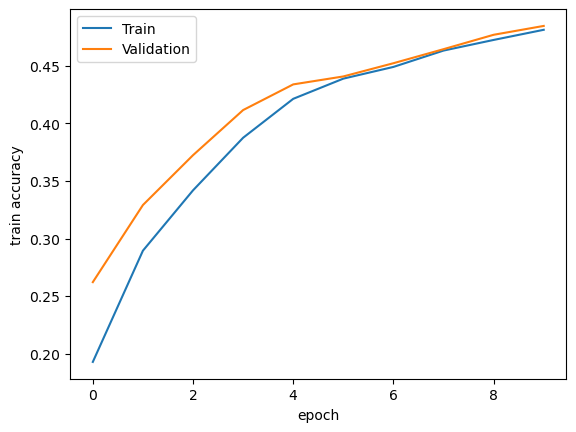

In [ ]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation')

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = Model1()
model.to(device)
with torch.no_grad():
    correct = 0
    for x_test, y_test in testloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        y_val = model(x_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len( testset)} = {correct.item()*100/(len(testset)):7.3f}%')

Test accuracy: 1012/10000 =  10.120%


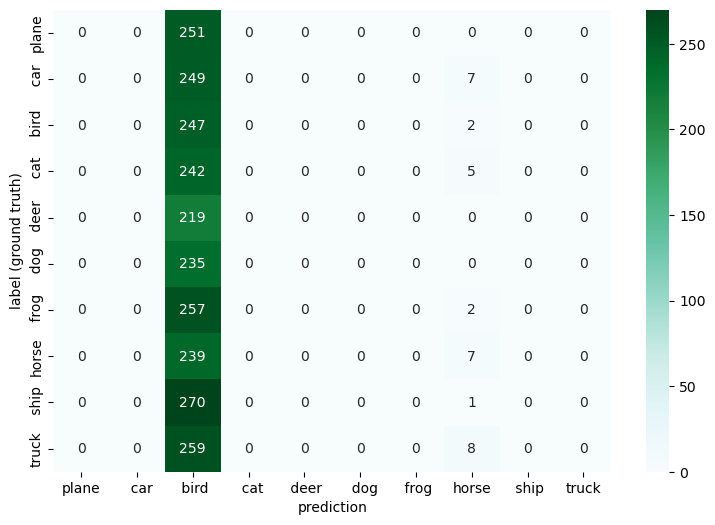

In [ ]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [9]:
lossfunc = nn.CrossEntropyLoss()
model = Model1
model1Results = trainNetwork(model, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)
print(model1Results)

    epoch  total time  train loss  total correct  val loss  train accuracy  \
0       0   11.461501   44.062179          10328  8.087990         0.20656   
1       1   22.637500   38.895046          14811  7.449880         0.29622   
2       2   33.891000   36.234796          17271  6.971594         0.34542   
3       3   44.598999   34.128576          19154  6.646924         0.38308   
4       4   54.970999   32.619129          20436  6.407498         0.40872   
5       5   65.719997   31.494471          21465  6.188424         0.42930   
6       6   76.463497   30.686511          22184  6.053353         0.44368   
7       7   87.468498   30.040014          22774  5.989719         0.45548   
8       8   98.114998   29.623310          23225  5.857986         0.46450   
9       9  108.787997   29.031565          23773  5.772774         0.47546   
10     10  119.311496   28.637606          24187  5.760467         0.48374   
11     11  129.817997   28.395017          24537  5.631227      

<Axes: xlabel='epoch', ylabel='train accuracy'>

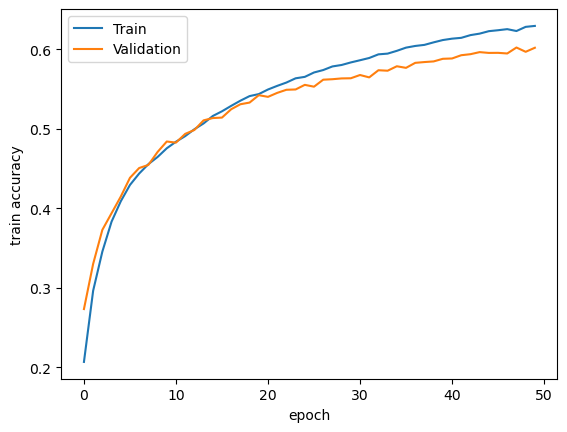

In [10]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation')

In [11]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = Model1()
model.to(device)
with torch.no_grad():
    correct = 0
    for x_test, y_test in testloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        y_val = model(x_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len( testset)} = {correct.item()*100/(len(testset)):7.3f}%')

Test accuracy: 1045/10000 =  10.450%


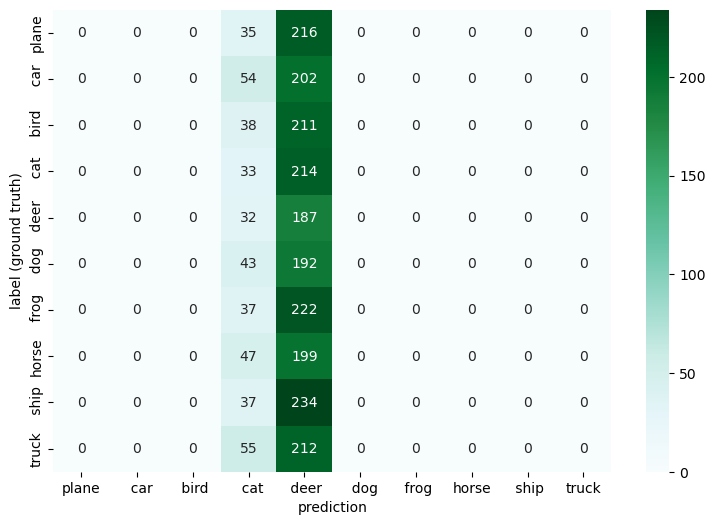

In [12]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [7]:
lossfunc = nn.CrossEntropyLoss()
model = Model2
model2Results = trainNetwork(model, lossfunc, trainloader = trainloader, valloader = valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)
print(model2Results)

    epoch  total time  train loss  total correct  val loss  train accuracy  \
0       0   10.427999   45.608854           6308  8.819233         0.12616   
1       1   20.904500   41.755146          10536  8.001955         0.21072   
2       2   31.057999   38.837387          13870  7.492502         0.27740   
3       3   41.287997   36.705765          16092  7.178330         0.32184   
4       4   51.387997   35.363707          17391  6.963140         0.34782   
5       5   61.632497   34.418436          18231  6.818038         0.36462   
6       6   72.729496   33.675097          18941  6.662336         0.37882   
7       7   83.498998   33.122244          19397  6.575501         0.38794   
8       8   93.948499   32.624572          19939  6.479173         0.39878   
9       9  104.592499   32.141486          20317  6.407598         0.40634   
10     10  115.000001   31.809981          20533  6.326843         0.41066   
11     11  125.629002   31.513947          20865  6.284227      

<Axes: xlabel='epoch', ylabel='train accuracy'>

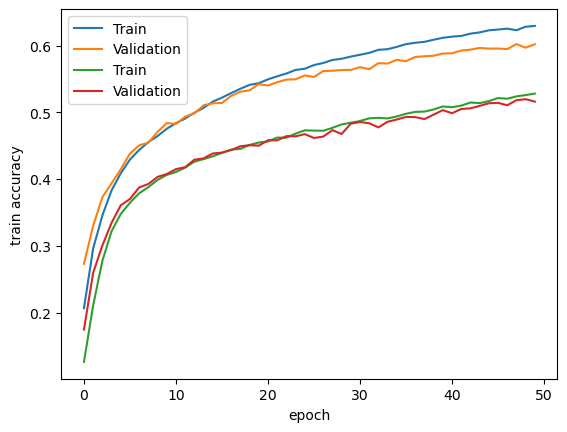

In [13]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation')
sns.lineplot(x='epoch', y ='train accuracy', data = model2Results, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model2Results, label = 'Validation')